# 모델 시각화

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


모델을 만드는 것 만큼이나 중요한 게 모들을 확인하는 것이다. 특히 모델을 만드는 순간에는 어떤 구조로 모델을 만드는지 기억이 잘 나지만, 조금만 시간이 지나도 이 모델을 왜 만들었는지, 왜 이런 구조로 만들었는지 파악하기가 힘들다. 내가 만든 모델만 하더라도 시간이 지나면 어려운데, 하물며 남이 만든 모델을 가져다 쓰는 경우에는 더 어려울 수 밖에 없다. 아래 처럼 완저닣 순차적이지 않은 경우는 더 그렇다

In [5]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(28*28, 32)
        self.dense2 = nn.Linear(28*28, 32)
        self.dense2_2= nn.Linear(32, 16)
        self.dense3 = nn.Linear(32+16, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x1 = self.dense1(x)
        x1 = self.relu(x1)

        x2_1 = self.dense2(x)
        x2_1 = self.relu(x2_1)
        x2_2 = self.dense2_2(x2_1)
        x2_2 = self.relu(x2_2)

        x = torch.cat([x1, x2_2], dim=1)
        x = self.dense3(x)

        return(x)
        

모델을 만들어보자. lightning 모듈을 상속받아서 만들었기 때문에, 이대로 돌아가지는 않는다. traning_step 이 정의되지 않았으므로..

그럼에도 불구하고 일단 모델 자체는 성공적으로 생성이 되는데, 이 구조를 보기위해서 호출을 해보면

In [ ]:
model = Model()

In [11]:
model

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=784, out_features=32, bias=True)
  (dense2): Linear(in_features=784, out_features=32, bias=True)
  (dense2_2): Linear(in_features=32, out_features=16, bias=True)
  (dense3): Linear(in_features=48, out_features=10, bias=True)
  (relu): ReLU()
)

위와 같이 아주 대략적인 정보를 알려준다. 여기서 나오는 레이어는 model 의 property에 해당하므로 필요하면 (중간 latent space확인이 필요한 경우등) 접근이 가능하지만, 이 모델의 구조를 파악하는데에는 그다지 쓸모가 없다. (단순히 In, out 의 shape 을 보여주고, 어떤 layer 가 있는지 파악하는 정도)

이를 위해 조금 더 자세한 정보를 출력해주는 요약(summary) 를 통해 모델을 파악해볼 수 있다. 이 때에는 input 으로 어떤 데이터가 들어갈지도 알려줘야 하는데, 기본적으로 input_size 는 (batch_size ,  chennel ,  width, height ) 로 구성되어 있다. 

In [12]:
summary(model, input_size = (1, 1, 28, 28) )

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 32]                   25,120
├─ReLU: 1-3                              [1, 32]                   --
├─Linear: 1-4                            [1, 32]                   25,120
├─ReLU: 1-5                              [1, 32]                   --
├─Linear: 1-6                            [1, 16]                   528
├─ReLU: 1-7                              [1, 16]                   --
├─Linear: 1-8                            [1, 10]                   490
Total params: 51,258
Trainable params: 51,258
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21

단순히 모델을 호출하는 것에 비해서 좀 더 자세한 정보가 나온다. 특히 Number of parameter의 경우 모델의 크기(학습가능한 노드)를 가늠하는데 도움을 준다. 나중에 다룰 transfer learning(전이학습) 의 경우 초반 feature out 에 해당하는 부분은 굳이 재학습을 할 필요가 없기 때문에, req_grad 항목을 꺼서 tensor가 학습되지 않도록 할 수 있느데, 그런 것들 (non-trainable params) 등을 확인할 수 있는 등 보다 많은 정보를 전달해준다.

다만 이 경우에도 아주 시각적으로 모델을 이해할 수 있게 해준다고 하기는 어렵다. 이럴때 사용하는 게 서드파티 라이브러리인 "onnx" 를 인데, 별도 페키지가 필요하므로 아래와 같이 실행하여 설치가 가능하다.

In [15]:
!pip install onnx

                                              0.0/13.3 MB ? eta -:--:--
                                              0.0/13.3 MB ? eta -:--:--
                                              0.0/13.3 MB ? eta -:--:--
                                             0.0/13.3 MB 325.1 kB/s eta 0:00:41
                                             0.1/13.3 MB 573.4 kB/s eta 0:00:24
                                             0.2/13.3 MB 893.0 kB/s eta 0:00:15
                                              0.3/13.3 MB 1.0 MB/s eta 0:00:13
     -                                        0.4/13.3 MB 1.3 MB/s eta 0:00:10
     -                                        0.4/13.3 MB 1.3 MB/s eta 0:00:10
     -                                        0.5/13.3 MB 1.4 MB/s eta 0:00:10
     -                                        0.6/13.3 MB 1.5 MB/s eta 0:00:09
     --                                       0.7/13.3 MB 1.6 MB/s eta 0:00:08
     --                                       0.8/13.3 MB 1.7 MB/s eta

In [18]:
device = 'cuda:0'
torch.onnx.export( model,  torch.zeros(8, 1, 28, 28).to(device), 'model.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



이렇게 실행시키면, 마지막 file_name이었던 'model.onnx' 라는 이름으로 파일이 생성된다. 이 파일은 말그대로 모델을 export 한 거나 마찬가지로 모델에 대한 모든 정보를 가지고 있는데, 이 이렇게 export 시킨 모델은 pytorch 뿐 아니라 다른 딥러닝 플랫폼에서도 실행시킬 수 있다. 즉 모델 자체(구조, weights 등등)를 파일로 내보냈다고 이해하면 된다. 이렇게 export 된 파일은 여러 시각화 툴을 활용해서 모델확인이 가능한데, 그 중에서도 추천하는건 NETRON("https://netron.app/") 를 활용한 방법이다. 별도 설치가 필요없고 웹상에서 그대로 모델만 로드하면 아래와 같이 구조를 보여준다. 

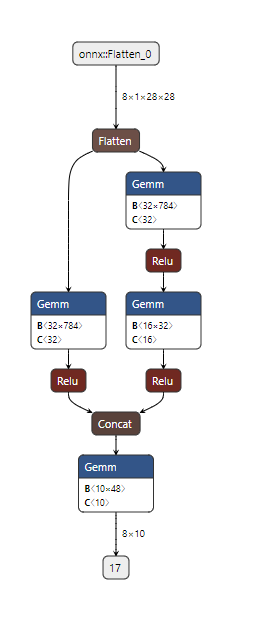

In [21]:
!pip install torchviz

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/47.0 kB ? eta -:--:--
     --------                                 10.2/47.0 kB ? eta -:--:--
     ----------------                       20.5/47.0 kB 330.3 kB/s eta 0:00:01
     ---------------------------------      41.0/47.0 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 391.5 kB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4137 sha256=b432b6f8f816232782cf867576f6ea0aafb249ad5b6968dba44aaed28bd0d7db
  Stored in directory: c:\users\msong\appdata\local\pip\cache\wheels\5a\d0\3f\b7014553eb74f12892b7d9b69c6083044564712d10fde8dfdc
Successfully built torchviz


In [22]:
from torchviz import make_dot

In [25]:
make_dot( model(torch.zeros(8, 1, 28, 28).to(device)),
         params=dict(list(model.named_parameters() )) )

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH